# <b>1 <span style='color:#4285f4'>|</span> Importing Libraries</b>
- **For ML Models**: tensorflow, keras  
- **For Data Processing**: numpy, pandas, sklearn  
- **For Data Visualization**: matplotlib, seaborn, plotly  

In [5]:
import streamlit as st
# For ML Models
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

# For Data Processing
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import *

# For Data Visualization
import matplotlib.pyplot as plt
import matplotlib
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import wordcloud

# Miscellaneous
from tqdm import tqdm
import os
import random
from IPython import display

# <b>2 <span style='color:#4285f4'>|</span> About the Dataset</b>

<h2>2.1 <span style='color:#4285f4'>|</span> Reading the data</h2>

In [7]:
df = pd.read_csv('dataset.csv')
df

,text,humor
0,"Joe biden rules out 2020 bid: 'guys, i'm not r...",False
1,Watch: darvish gave hitter whiplash with slow ...,False
2,What do you call a turtle without its shell? d...,True
3,5 reasons the 2016 election feels so personal,False
4,"Pasco police shot mexican migrant from behind,...",False
...,...,...
199995,Conor maynard seamlessly fits old-school r&b h...,False
199996,How to you make holy water? you boil the hell ...,True
199997,How many optometrists does it take to screw in...,True
199998,Mcdonald's will officially kick off all-day br...,False


<h2>2.2 <span style='color:#4285f4'>|</span> Distribution of Humor</h2>

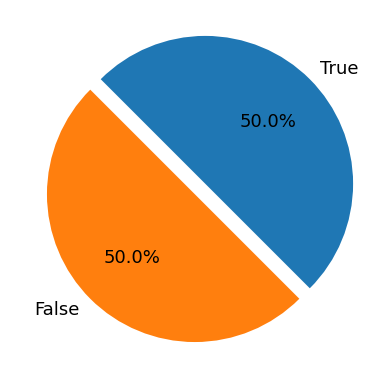

In [3]:
plt.rcParams.update({'font.size': 13})
label = ['True', 'False']
count = [len(df[df['humor']==True]),
         len(df[df['humor']==False])]

plt.pie(count, labels = label, startangle=-45, explode=[0.1,0], autopct='%.1f%%')
plt.show()

#### The dataset is perfectly balanced

# <b>3 <span style='color:#4285f4'>|</span> Data Preprocessing</b>

<h2>3.1 <span style='color:#4285f4'>|</span> Tokenizer</h2>

In [8]:
tokenizer = Tokenizer(filters='"&(),-/:;<=>[\\]_`{|}~\t\n0123456789',
                      lower=True, split=' ')
tokenizer.fit_on_texts(np.array(df['text']))
vocab_size = len(tokenizer.word_index) + 1

In [5]:
lengths=[]
for x in range(len(df)):
    i = df['text'][x]
    i = tokenizer.texts_to_sequences([i])
    lengths.append(len(i[0]))
lengths = np.array(lengths)
""" sns.set(rc={'figure.figsize':(16,6)})
fig = sns.histplot(lengths, kde=False, bins=25)
plt.xlabel('Length of Sentence (in words)')
plt.axvline(x=lengths.mean(),
            color='red',ls='--', label="mean")
plt.legend(loc='upper right', prop={'size': 12})
plt.show(fig) """

' sns.set(rc={\'figure.figsize\':(16,6)})\nfig = sns.histplot(lengths, kde=False, bins=25)\nplt.xlabel(\'Length of Sentence (in words)\')\nplt.axvline(x=lengths.mean(),\n            color=\'red\',ls=\'--\', label="mean")\nplt.legend(loc=\'upper right\', prop={\'size\': 12})\nplt.show(fig) '

#### Here I am setting the maximum length of a sentence to be 15 words  

In [9]:
maxlen = 15

<h2>3.2 <span style='color:#4285f4'>|</span> Encode </h2>

In [7]:
df['humor'] = df['humor'].apply(lambda x: {True:1, False:0}.get(x))
texts = np.array(df['text'])
texts = tokenizer.texts_to_sequences(texts)
for x in range(len(texts)):
    if len(texts[x])>maxlen:
        texts[x]=texts[x][:maxlen]
texts = pad_sequences(texts, maxlen=maxlen, dtype='float', padding='post', value=0.0)
texts = np.array(texts)
labels = df['humor']
labels = np.array([float(j) for j in labels])

<h2>3.3 <span style='color:#4285f4'>|</span> Train-Test Split</h2>

In [8]:
x_train, x_val, y_train, y_val = train_test_split(texts, labels, test_size=0.2, random_state=0)

# <b>4 <span style='color:#4285f4'>|</span> Model</b>

#### I am using the embedding matrix [glove.twitter.27B.100d.txt](https://www.kaggle.com/mushfirat/glove-pretrained-embeddings?select=glove.twitter.27B.100d.txt) from [Glove Pretrained Embeddings](https://www.kaggle.com/mushfirat/glove-pretrained-embeddings) dataset which I have attached to this notebook

<h2>4.1 <span style='color:#4285f4'>|</span> Load Embedding Matrix</h2>

In [9]:
""" embeddings_index = dict()
f = open('/kaggle/input/glove-pretrained-embeddings/glove.twitter.27B.25d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

embedding_matrix = np.zeros((vocab_size, 25))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector """

" embeddings_index = dict()\nf = open('/kaggle/input/glove-pretrained-embeddings/glove.twitter.27B.25d.txt')\nfor line in f:\n    values = line.split()\n    word = values[0]\n    coefs = np.asarray(values[1:], dtype='float32')\n    embeddings_index[word] = coefs\nf.close()\n\nembedding_matrix = np.zeros((vocab_size, 25))\nfor word, i in tokenizer.word_index.items():\n    embedding_vector = embeddings_index.get(word)\n    if embedding_vector is not None:\n        embedding_matrix[i] = embedding_vector "

<h2>4.2 <span style='color:#4285f4'>|</span> Build Model</h2>

I have shown how to load the embedding matrix above, and to load these weights to a keras layer, simply mention the `weights` parameter when creating an embedding layer. Like this:
```
Embedding(vocab_size, embedding_dimension, weights=[embedding_matrix], input_length=maxlen, trainable=True)
```
But using this pretrained embedding matrix does not give us a better score (Check version 5 of this notebook). So, I am training the embeddings from scratch.

In [10]:
model = Sequential()
model.add(Input(shape=(maxlen)))
model.add(Embedding(vocab_size, 8, input_length=maxlen))
#model.add(Bidirectional(LSTM(16, activation='relu',dropout=0.15, return_sequences=True), merge_mode='concat'))
#model.add(TimeDistributed(Dense(16, activation='relu')))
model.add(LSTM(64, activation='relu',dropout=0.15, return_sequences=False))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(2, activation='softmax'))

KeyboardInterrupt: 

In [ ]:
mc = ModelCheckpoint('model.h4', monitor='val_sparse_categorical_accuracy', mode='max', verbose=1, save_best_only=True)

RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 15, 8)             892912    
                                                                 
 lstm_2 (LSTM)               (None, 64)                18688     
                                                                 
 flatten_1 (Flatten)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 2)                 130       
                                                                 
Total params: 915,890
Trainable params: 915,890
Non-tr

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
             metrics=['sparse_categorical_accuracy'])

In [ ]:
history = model.fit(x_train, y_train, epochs=20, batch_size=8192, validation_data=(x_val, y_val), callbacks=[mc])

Epoch 1/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
20/20 [==============================] - ETA: 0s - loss: 0.6924 - sparse_categorical_accuracy: 0.5937WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x0000026674B6C940> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10

FailedPreconditionError: model.h4\variables is not a directory

<h2>4.3 <span style='color:#4285f4'>|</span> Train Model</h2>

In [ ]:
epochs = 30
#mc = ModelCheckpoint('model.h5', monitor='val_sparse_categorical_accuracy', mode='max', verbose=1, save_best_only=True)
history = model.fit(x_train, y_train, epochs=epochs, batch_size=8192, validation_data=(x_val, y_val), callbacks=[mc])

Epoch 1/30
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
20/20 [==============================] - ETA: 0s - loss: 0.6921 - sparse_categorical_accuracy: 0.5532WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000002668771BC70> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert

Epoch 1: val_sparse_categorical_accuracy did not improve from 0.69037
20/20 [==============================] - 14s 635ms/step - loss: 0.6921 - sparse_categorical_accuracy: 0.5532 - val_loss: 0.6911 - val_sparse_categorical_accuracy: 0.6422
Epoch 2/30
20/20 [==============================] - ETA: 0s - loss: 0.6903 - sparse_categorical_accuracy: 0.6690
Epoch 2: val_sparse_categorical_accuracy did not improve from 0.69037
20/20 [==============================] - 13s 646ms/step - loss: 0.6903 - sparse_categorical_accuracy: 0.6690 - val_loss: 0.6890 - val_sparse_categorical_accuracy: 0.6902
Epoch 3/30
20/20 [==============================] - ETA: 0s - loss: 0.6880 - sparse_categorical_accurac

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid value for "node": expected "ast.AST", got "<class 'NoneType'>"; to visit lists of nodes, use "visit_block" instead
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid value for "node": expected "ast.AST", got "<class 'NoneType'>"; to visit lists of nodes, use "visit_block" instead
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


FailedPreconditionError: model.h4\variables is not a directory

<h2>4.4 <span style='color:#4285f4'>|</span> Evaluate Model</h2>

In [ ]:
decode_label = {0:'False', 1:'True'}

y_pred = []
y_true = []

pred = model.predict(x_val)
pred = np.argmax(pred, axis=-1)

y = [decode_label[int(i)] for i in y_val]
pred = [decode_label[int(i)] for i in pred]

for i in pred:
    y_pred.append(i)
    
for i in y:
    y_true.append(i)
    
print(classification_report(y_true, y_pred, digits=3))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


1250/1250 [==============================] - 6s 4ms/step
              precision    recall  f1-score   support

       False      0.951     0.956     0.953     19973
        True      0.955     0.951     0.953     20027

    accuracy                          0.953     40000
   macro avg      0.953     0.953     0.953     40000
weighted avg      0.953     0.953     0.953     40000



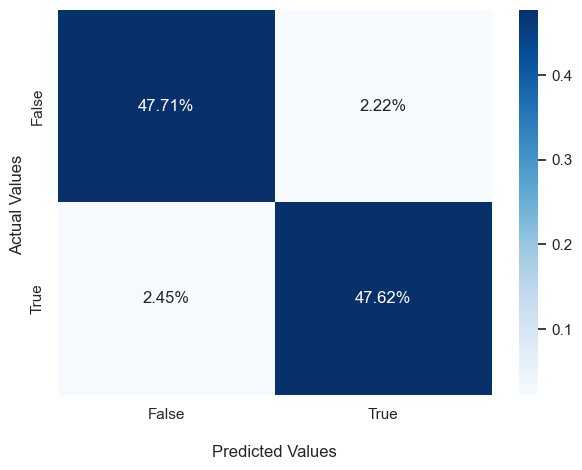

In [ ]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(7,5))

ax = sns.heatmap(cm/np.sum(cm),fmt='.2%', annot=True, cmap='Blues')

ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

plt.show()

# <b>5 <span style='color:#4285f4'>|</span> Inference</b>

In [15]:
#model=keras.Model()
#model.load_weights('model.keras')
model=load_model('modello.h5')

In [16]:
def predict(text):
    text = tokenizer.texts_to_sequences([text])
    if len(text)>maxlen:
        text=text[:maxlen]
    text = pad_sequences(text, maxlen=maxlen, dtype='float', padding='post', value=0.0)
    text = np.array(text)
    pred = model.predict(text)
    pred = np.argmax(pred, axis=-1)
    decode_label = {0:'False', 1:'True'}
    pred = decode_label[pred[0]]
    return pred

In [17]:
text = "what's the difference between donald trump's hair and a wet racoon"
pred = predict(text)
print("Text:",text)
print('Humor detected: ',pred)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1/1 [==============================] - 0s 485ms/step
Text: what's the difference between donald trump's hair and a wet racoon
Humor detected:  True


In [ ]:
text = "Artificial Intelligence is becoming better at language"
pred = predict(text)
print("Text:",text)
print('Humor detected: ',pred)

1/1 [==============================] - 0s 25ms/step
Text: Artificial Intelligence is becoming better at language
Humor detected:  False


In [ ]:
text = "people say time is precious but they waste it right after they say it themselves"
pred = predict(text)
print("Text:",text)
print('Humor detected: ',pred)

1/1 [==============================] - 0s 26ms/step
Text: people say time is precious but they waste it right after they say it themselves
Humor detected:  True


In [ ]:
text = "The earth is flat"
pred = predict(text)
print("Text:",text)
print('Humor detected: ',pred)

1/1 [==============================] - 0s 29ms/step
Text: The earth is flat
Humor detected:  False


In [ ]:
st.write("Enter a funny joke")

inp=st.text_input(label, value="", max_chars=None, key=None, type="default", help=None, autocomplete="Write your joke here", on_change=None, args=None, kwargs=None, *, placeholder=None, disabled=False, label_visibility="visible")